In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [2]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train,test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
train['Has_Cabin'] = train["Cabin"].apply(lambda x:0 if type(x)==float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x:0 if type(x)==float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch']+1
    
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1,'IsAlone'] = 1
    
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'],5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)

    title_mapping = {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454),'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31),'Fare'] = 2
    dataset.loc[dataset['Fare']>31,'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age']<=16,'Age'] = 0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32),'Age'] = 1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48),'Age'] = 2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64),'Age'] = 3
    dataset.loc[dataset['Age']>64,'Age'] = 4    

In [4]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements,axis=1)
train = train.drop(['CategoricalAge','CategoricalFare'],axis=1)
test = test.drop(drop_elements,axis=1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


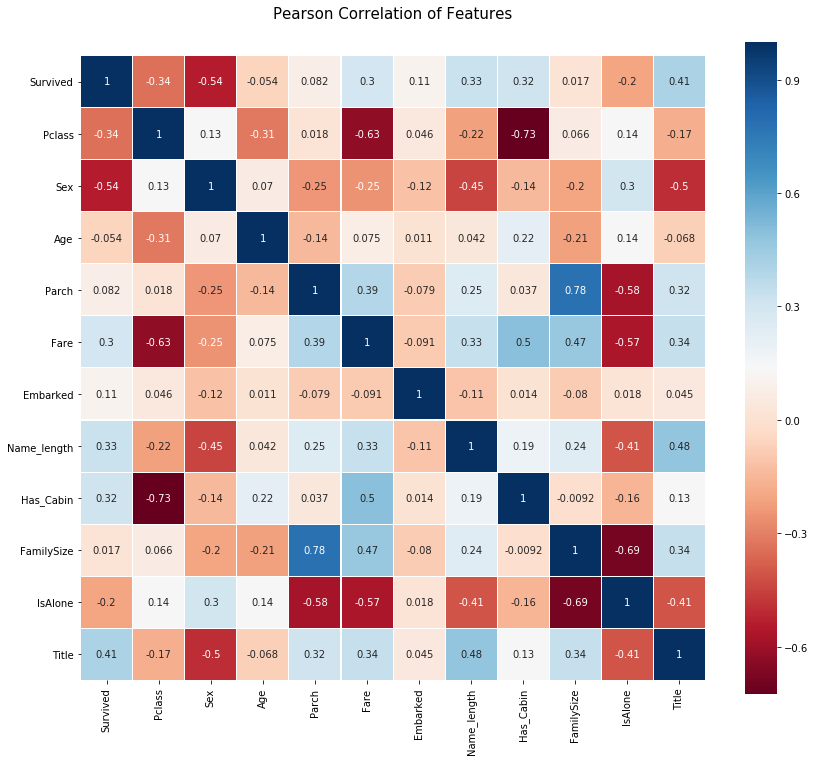

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train.astype(float).corr(),linewidth=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

LinAlgError: singular matrix

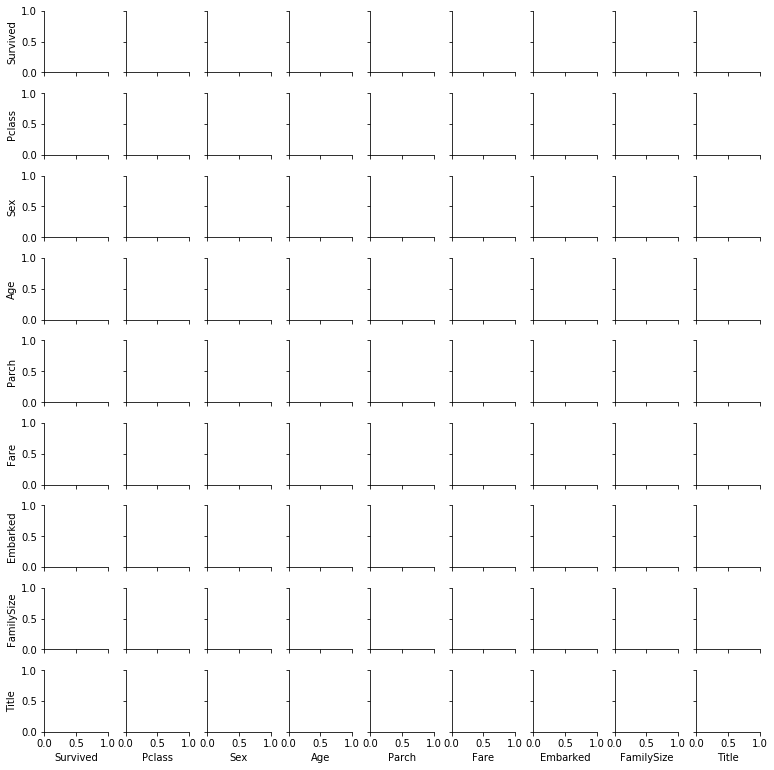

In [7]:
g = sns.pairplot(train[[u'Survived',u'Pclass',u'Sex',u'Age',u'Parch',u'Fare',u'Embarked',u'FamilySize',u'Title']],hue='Survived',palette='seismic',size=1.2,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

In [8]:
train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,1,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3
